# DFO Code Sample for Imputation

Tor Kitching


December 12, 2022


Conda Env: pymc3_env

## Package Installations and Function Calls

In [73]:
import requests
import pandas as pd
import random
import numpy as np
import math
import scipy
import numpy.ma as ma
from matplotlib import pyplot as plt
import matplotlib as mpl
import statistics
import seaborn as sns
import pymc as pm
import arviz as az
from datetime import datetime

The following function converts string months into their numeric value.

In [74]:
def date_convert(date_to_convert):
     return datetime.strptime(date_to_convert, '%B').month

## Data Calls

The following reads in the River Temperatures from the river monitored dataset and the air temperatures drawn from the FROST API.

In [114]:
River_temp = pd.read_csv("River_temperatures_blank.csv")

Air_temp = pd.read_csv('Air_temperatures_blank.csv')

## Data Cleaning and Initiation

Now that the two sets are in their own dataframes, we need to make a few conversions in data types.


1. Convert months from strings to a numerical form using the date_convert function created earlier.
2. Convert months and years to floats in order to facilitate a merge.
3. Rename select column headers to facilitate a merge.
4. Merge the river temperature and air temperature sets by year, month, and day.
5. Create a final reduced dataset without NA's in the new merged set.


In [115]:
# 1. Apply function date_convert to river temperature's month column
River_temp['Month'] = River_temp['Month'].astype(str).apply(date_convert)

# 2. Type conversions for months and years from strings to floats
River_temp['Month'] = River_temp['Month'].astype(str).astype(float)
River_temp['Year of fishing'] = River_temp['Year of fishing'].astype(str).astype(float)

In [116]:
# 3. Rename river temperature set column headers
River_temp = River_temp.rename(columns={"Year of fishing": "Year", "Day nr.": "Day"})

# 3.b Create a single date variable. Used in plotting the timeseries.
River_temp['date'] = pd.to_datetime(River_temp[['Day','Month','Year']],errors='coerce')

In [118]:
# 4. Merge river and air temperature sets. Left join by year, month, and day
t_merged = pd.merge(River_temp, Air_temp, how='left', left_on= ['Year of fishing','Month','Day nr.'], right_on = ['year', 'month', 'day'])

In [119]:
# 4.5 Remove unnecessary columns to reduce size of dataframe.

In [121]:
# 5. Drop NA's in temperature and value columns for redundancy
t_merged_dna = t_merged.dropna(subset=['river_temp','air_temp'])

Now that the sets are merged, I would like to take a look at the river temperature timeseries to understand what kind of holes I am hoping to fill.

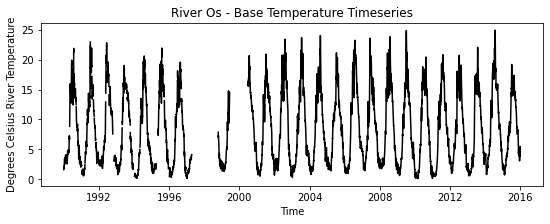

In [122]:
#River_temp = River_temp.rename(columns={"Year of fishing": "Year", "Day nr.": "Day"})
#River_temp['date'] = pd.to_datetime(River_temp[['Day','Month','Year']],errors='coerce')
plt.figure(figsize=(9,3))
plt.plot(River_temp['date'], River_temp['river_temp'], color='black')
plt.xlabel('Time')
plt.ylabel('Degrees Celsius River Temperature')
plt.title('River Os - Base Temperature Timeseries');

Finally, check the distributions of river and air temperatures before assuming priors.

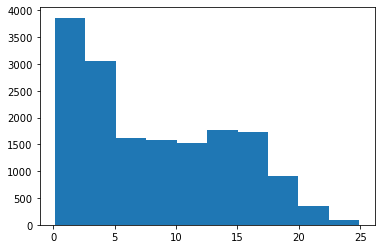

In [123]:
plt.hist(t_merged_dna['river_temp']);

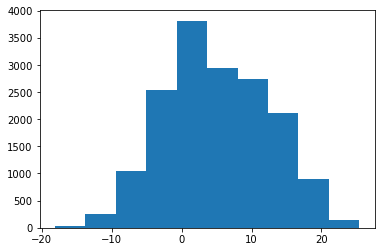

In [124]:
plt.hist(t_merged_dna['air_temp']);

## Model

In order to impute the holes in the river temperature dataset. I am going to estimate the relationship between air temperature and river temperature. I will create a basic linear model, assuming that both air and river temperatures behave in a normal fashion. Once this model is run, I will have access to the posterior distributions of the estimated parameters and can then calculate the expected river temperatures that the dataset is missing.


The proceeding model reads: The probability of observing y (river temperature) is a normal distribution defined by mu (with an intercept and slope affected by air temperature) with a variance sigma. The estimated parameters: a and b have semi-informative normal priors, and sigma is assumed to have a Half Cauchy distribution.

In [89]:
# setup parameters for temperature relationships
x_ = np.asarray(t_merged_dna['air_temp'])

y_ = np.asarray(t_merged_dna['river_temp'])

In [90]:
with pm.Model() as t_linear:
    
    a = pm.Normal('a',mu=0, sigma = 5) # intercept
    b = pm.Normal('b',mu=0, sigma = 5) # slope
    
    sigma = pm.HalfCauchy('Sigma', 0.5) # error of observed

    mu_ = a + b*x_ # linear equation, where x_ is air temperature
    
    mu_ = mu_*1 # normalizing function
    
    y_obs = pm.Normal('y_obs', mu_ , sigma, observed=y_) # n=100, for binomial
    # the observed predicted variable, where the observed values are river temperature

In [91]:
with t_linear:
    trace_t_linear = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, Sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
The acceptance probability does not match the target. It is 0.9963, but should be close to 0.8. Try to increase the number of tuning steps.


## Model Outputs

Once the model has run, a check of the posterior distributions to confirm no issues with the sampling chains.

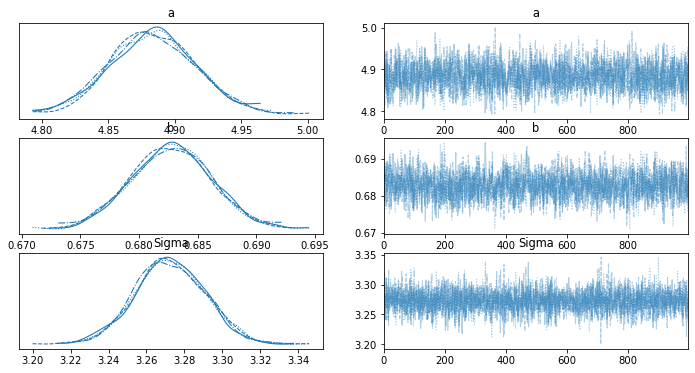

In [92]:
az.plot_trace(trace_t_linear);

And a second check of the summary statistics for the estimated parameters.

In [93]:
az.summary(trace_t_linear, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.88,0.03,4.83,4.95,0.0,0.0,2229.65,2028.32,1.0
b,0.68,0.00,0.68,0.69,0.0,0.0,2430.36,2378.84,1.0
Sigma,3.27,0.02,3.24,3.31,0.0,0.0,3914.11,2438.30,1.0


## Completing the dataset

The following function applys the model with the new estimated parameters to whenever there is a river temperature value missing.

In [125]:
t_merged['river_temp'] = t_merged .apply(
    lambda row: np.mean(trace_linear_o.posterior.a.values) + np.mean(trace_linear_o.posterior.b.values)*row['air_temp'] 
        if np.isnan(row['river_temp']) 
            else row['river_temp'],
    axis=1
)

Finally, create a new reduced dataframe without redundancies.

In [126]:
t_merged

,Month,Day nr.,Year of fishing,river_temp,date,year,month,day,air_temp
0,1.0,1,1990.0,1.610000,1990-01-01,1990.0,1.0,1.0,-6.7
1,1.0,1,1990.0,1.610000,1990-01-01,1990.0,1.0,1.0,-0.2
2,1.0,2,1990.0,1.840000,1990-01-02,1990.0,1.0,2.0,-5.9
3,1.0,2,1990.0,1.840000,1990-01-02,1990.0,1.0,2.0,-4.0
4,1.0,3,1990.0,1.950000,1990-01-03,1990.0,1.0,3.0,-7.6
...,...,...,...,...,...,...,...,...,...
20469,12.0,29,2017.0,4.679317,2017-12-29,2017.0,12.0,29.0,-0.3
20470,12.0,29,2017.0,0.242229,2017-12-29,2017.0,12.0,29.0,-6.8
20471,12.0,30,2017.0,2.563167,2017-12-30,2017.0,12.0,30.0,-3.4
20472,12.0,30,2017.0,3.245796,2017-12-30,2017.0,12.0,30.0,-2.4


In [127]:
River_temp_nu = t_merged[['river_temp','date','Month','Day nr.','Year of fishing']].copy()
River_temp_nu = River_temp_nu.iloc[:,[1,4,2,3,0]]

Lastly before the final step of visualization, check to see if there are remaining Na's.

In [128]:
River_temp_nu['river_temp'].isna().sum()

22

In [129]:
River_temp_nu[River_temp_nu['river_temp'].isna()]

,date,Year of fishing,Month,Day nr.,river_temp
118,NaT,1990.0,2.0,29,NaN
849,NaT,1991.0,2.0,29,NaN
2312,NaT,1993.0,2.0,29,NaN
3043,NaT,1994.0,2.0,29,NaN
3774,NaT,1995.0,2.0,29,NaN
5237,NaT,1997.0,2.0,29,NaN
5968,NaT,1998.0,2.0,29,NaN
6699,NaT,1999.0,2.0,29,NaN
8162,NaT,2001.0,2.0,29,NaN
8893,NaT,2002.0,2.0,29,NaN


February 29th is a leap-day, therefore I am not concerned that it has been left out.


Upon checking the original FROST API call - the 31st of December 2017 was cut-off. It is also outside of the original timeseries - therefore I am not concerned.

## Visualization

The final step is to visually check what the imputation looks like. I created two separate views: (1) with the complete timeseries, and (2) a zoomed in feature of one of the largest gaps.

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(River_temp['date'], River_temp['river_temp'], color='black')
plt.plot(River_temp_nu['date'], River_temp_nu['river_temp'], color='blue', alpha = 0.15)
plt.ylabel('Temperature ˚C', fontsize = 16)
plt.title('River Os', fontsize = 16)
plt.ylim(-10, 26);

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(River_temp['date'], River_temp['river_temp'], color='black')
plt.plot(t_merged['date'], t_merged['river_temp'], color='blue', alpha = 0.15)
plt.ylabel('Temperature ˚C', fontsize = 16)
plt.title('River Os', fontsize = 16)
plt.ylim(-10, 26)
plt.xlim(9000,12000);